# Butterfly Images Multilabel Classification Problem

Dependencies import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SparseCategoricalAccuracy, Precision, Recall
from tensorflow.keras.models import load_model
import seaborn as sns
import math
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from collections import Counter

2024-05-17 10:18:29.061910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data load and getting information from the dataset.

In [2]:
# Load the data
folder_path = "./leedsbutterfly/images"

# Read all filenames in the folder
filenames = os.listdir(folder_path)

# Extract categories from the filenames
categories = {}
for filename in filenames:
    imagename, _ = os.path.splitext(filename)
    if imagename[1:3].isdigit(): 
        # Extract the category
        category = int(imagename[1:3])  
        categories[filename] = category

# Preprocessing images
image_size = (128, 128)  
images = []
original_labels = []
for filename in categories.keys(): 
    image_path = os.path.join(folder_path, filename)
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    images.append(img_array)
    
    # Set original_labels based on categories
    original_labels.append(categories[filename])


print(f"There are total {len(images)} images in this dataset.")


There are total 832 images in this dataset.


### There are only 832 images in the whole dataset. That is not enough to train a proper model therefore data augmentation is necessary.

In [3]:
# Implement the data augmentation generator again for sanity check
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Check augmented images and labels
augmented_images = []
augmented_labels = []
for img_array, label in zip(images, original_labels):
    img_array = np.expand_dims(img_array, axis=0)
    augmented_imgs_gen = datagen.flow(img_array, batch_size=1)
    for _ in range(4):
        augmented_img = next(augmented_imgs_gen)[0].astype(np.float32)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Combine original and augmented images
all_images = images + augmented_images
all_labels = original_labels + augmented_labels

# Convert to numpy array and normalize
all_images_array = np.array(all_images)
all_images_normalized = all_images_array.astype('float32') / 255.0

# Check if images are normalized correctly
print(f"Min pixel value after normalization: {all_images_normalized.min()}, Max pixel value after normalization: {all_images_normalized.max()}")

Min pixel value after normalization: 0.0, Max pixel value after normalization: 1.0


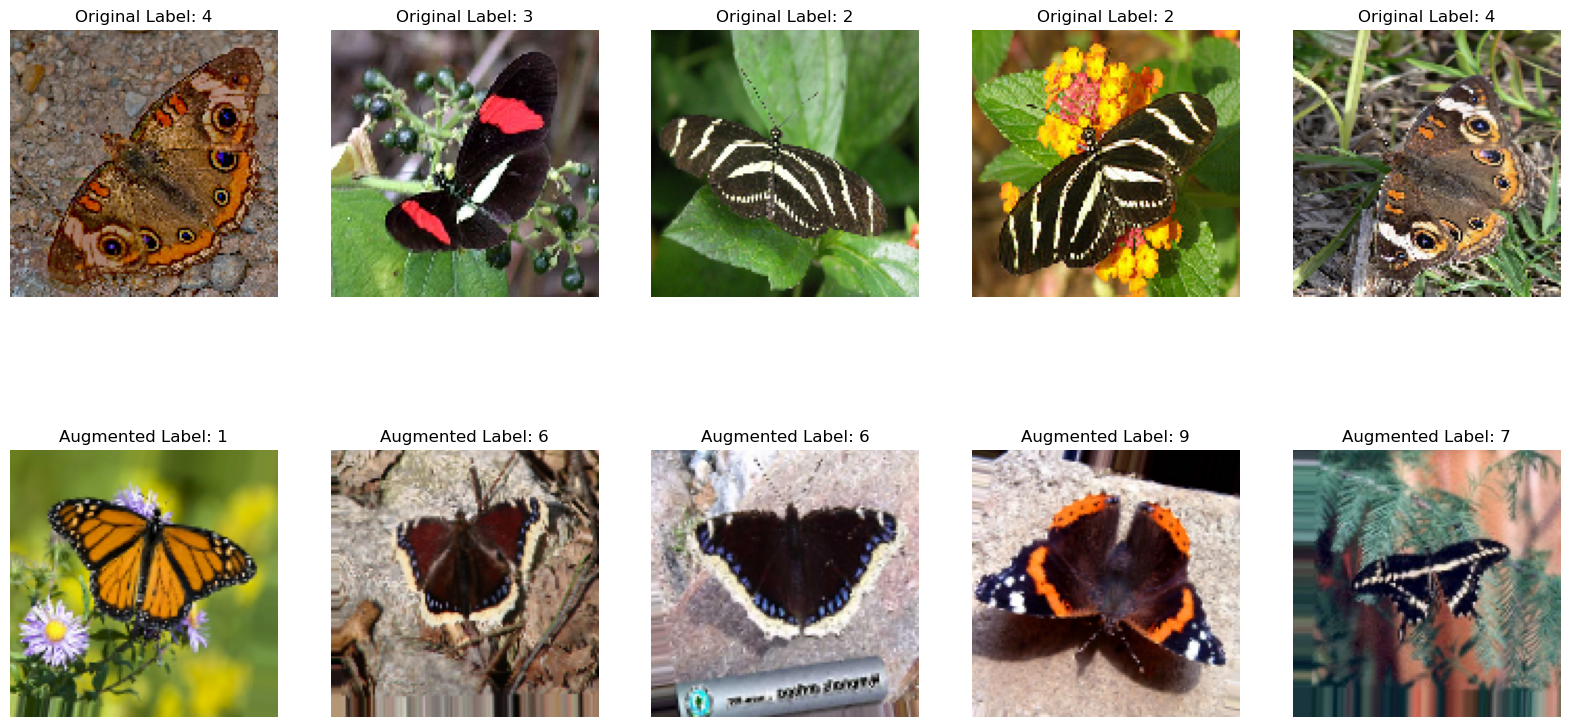

In [26]:
def plot_random_images(original_images, augmented_images, original_labels, augmented_labels, num_images=5):
    """
    Plots random original and augmented images with their labels.
    
    Parameters:
    - original_images: list or array of original images
    - augmented_images: list or array of augmented images
    - original_labels: list of original labels
    - augmented_labels: list of augmented labels
    - num_images: number of images to plot (default is 5)
    """
    
    # Plot random original images
    plt.figure(figsize=(20, 10))
    random_indices = random.sample(range(len(original_images)), num_images)
    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[idx].astype('uint8'))
        plt.title(f"Original Label: {original_labels[idx]}")
        plt.axis('off')
    
    # Plot random augmented images
    random_indices = random.sample(range(len(augmented_images)), num_images)
    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(augmented_images[idx].astype('uint8'))
        plt.title(f"Augmented Label: {augmented_labels[idx]}")
        plt.axis('off')
    
    plt.show()

# Example usage
plot_random_images(images, augmented_images, original_labels, augmented_labels, num_images=5)

## Splitting data for training.

Since there are 10 classes in labels but the arrays start numeration from zero, the substraction of 1 is required to prove a correct matching. 

In [4]:
train_mixed_images_normalized, val_mixed_images_normalized, train_mixed_labels, val_mixed_labels = train_test_split(
    all_images_normalized, all_labels, test_size=0.4, random_state=42)

val_mixed_images_normalized, test_mixed_images_normalized, val_mixed_labels, test_mixed_labels = train_test_split(
    val_mixed_images_normalized, val_mixed_labels, test_size=0.5, random_state=42)

# Convert labels to numpy arrays
train_mixed_labels = np.array(train_mixed_labels) - 1
val_mixed_labels = np.array(val_mixed_labels) - 1
test_mixed_labels = np.array(test_mixed_labels) - 1

# Model training

Firstly a simple model was created to see what would be the final accuracy. 

In [5]:
# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [6]:
# Define a model with data augmentation
augmented_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    #BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model with a lower initial learning rate
augmented_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Print the model summary
augmented_model.summary()

/opt/anaconda3/envs/adls_nn/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,550,474 (24.99 MB)

 Trainable params: 6,550,346 (24.99 MB)

 Non-trainable params: 128 (512.00 B)

In [7]:
# Train the model 
history_augmented = augmented_model.fit(train_mixed_images_normalized, train_mixed_labels,
                                        epochs=30,  
                                        validation_data=(val_mixed_images_normalized, val_mixed_labels),
                                        callbacks=[early_stopping, reduce_lr])  

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 433ms/step - accuracy: 0.3459 - loss: 1.8403 - val_accuracy: 0.4784 - val_loss: 2.0586 - learning_rate: 1.0000e-04
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 578ms/step - accuracy: 0.7560 - loss: 0.7287 - val_accuracy: 0.6190 - val_loss: 1.8041 - learning_rate: 1.0000e-04
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 476ms/step - accuracy: 0.8880 - loss: 0.3688 - val_accuracy: 0.6923 - val_loss: 1.4771 - learning_rate: 1.0000e-04
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 463ms/step - accuracy: 0.9516 - loss: 0.2022 - val_accuracy: 0.7272 - val_loss: 1.1198 - learning_rate: 1.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 467ms/step - accuracy: 0.9895 - loss: 0.1132 - val_accuracy: 0.8257 - val_loss: 0.7644 - learning_rate: 1.0000e-04
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - accuracy: 0.9966 - loss: 0.0453 - val_accuracy: 0.8077 - val_loss: 0.6155 - learning_rate: 1.0000e-04
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 451ms/step - acc

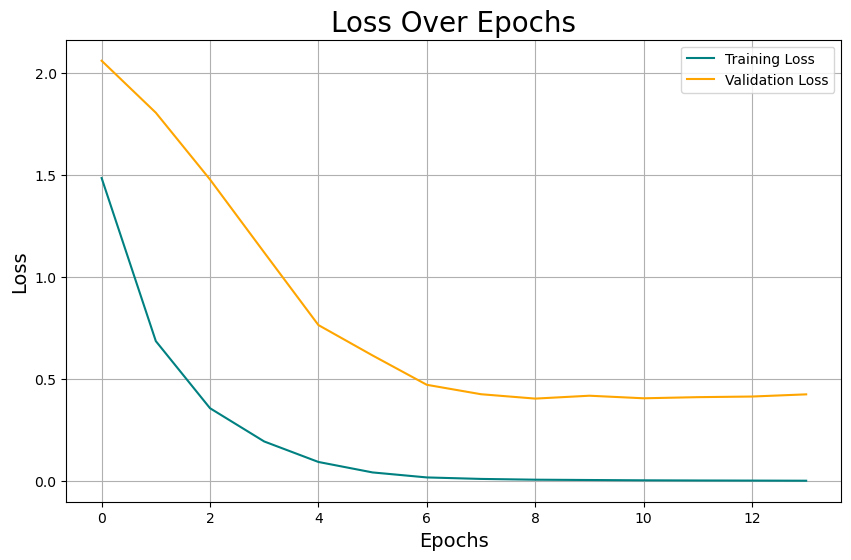

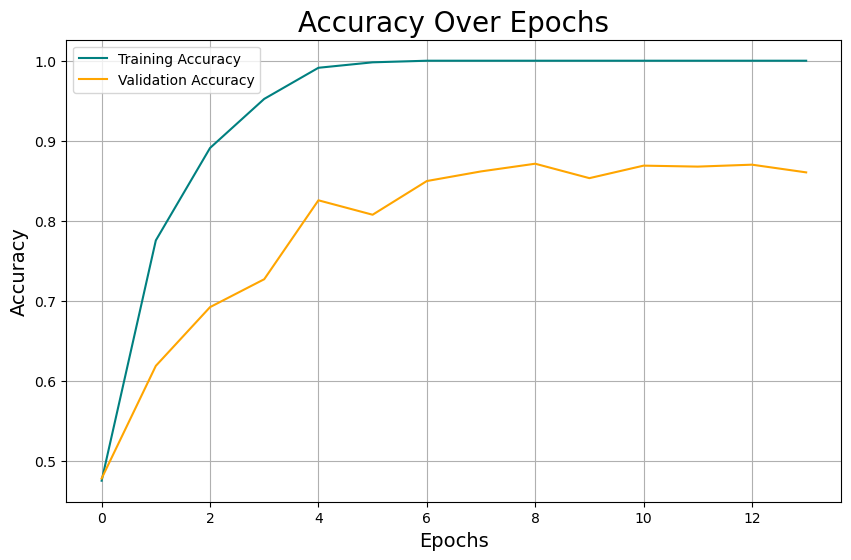

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8563 - loss: 0.4409
Test accuracy: 0.8677884340286255


In [8]:
# Plot performance (loss)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['loss'], color='teal', label='Training Loss')
plt.plot(history_augmented.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot performance (accuracy)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = augmented_model.evaluate(test_mixed_images_normalized, test_mixed_labels)

# Print the test accuracy
print(f"Test accuracy: {test_acc}")

In [9]:
#save tge model 
augmented_model.save("augmented_model_last_1.keras")
print("Model saved")

Model saved


# Improved Model 
In order to avoid overfitting some dropout layers were added and batches were normalized.

In [10]:
# Improved model architecture with Batch Normalization
augmented_model_upd = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# Compile the model with a lower initial learning rate
augmented_model_upd.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Print the model summary
augmented_model_upd.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,551,114 (24.99 MB)

 Trainable params: 6,550,666 (24.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Train the model 
history_augmented_upd = augmented_model_upd.fit(train_mixed_images_normalized, train_mixed_labels,
                                        epochs=30,  
                                        validation_data=(val_mixed_images_normalized, val_mixed_labels),
                                        callbacks=[early_stopping, reduce_lr])  

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 596ms/step - accuracy: 0.2731 - loss: 2.5105 - val_accuracy: 0.0685 - val_loss: 4.8761 - learning_rate: 1.0000e-04
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 577ms/step - accuracy: 0.6386 - loss: 1.0776 - val_accuracy: 0.0685 - val_loss: 7.3003 - learning_rate: 1.0000e-04
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 578ms/step - accuracy: 0.7795 - loss: 0.6739 - val_accuracy: 0.0913 - val_loss: 5.2392 - learning_rate: 1.0000e-04
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 578ms/step - accuracy: 0.8510 - loss: 0.4641 - val_accuracy: 0.2704 - val_loss: 3.0689 - learning_rate: 1.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 598ms/step - accuracy: 0.9090 - loss: 0.3030 - val_accuracy: 0.3870 - val_loss: 2.5308 - learning_rate: 1.0000e-04
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 580ms/step - accuracy: 0.9284 - loss: 0.2330 - val_accuracy: 0.5252 - val_loss: 1.6870 - learning_rate: 1.0000e-04
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - acc

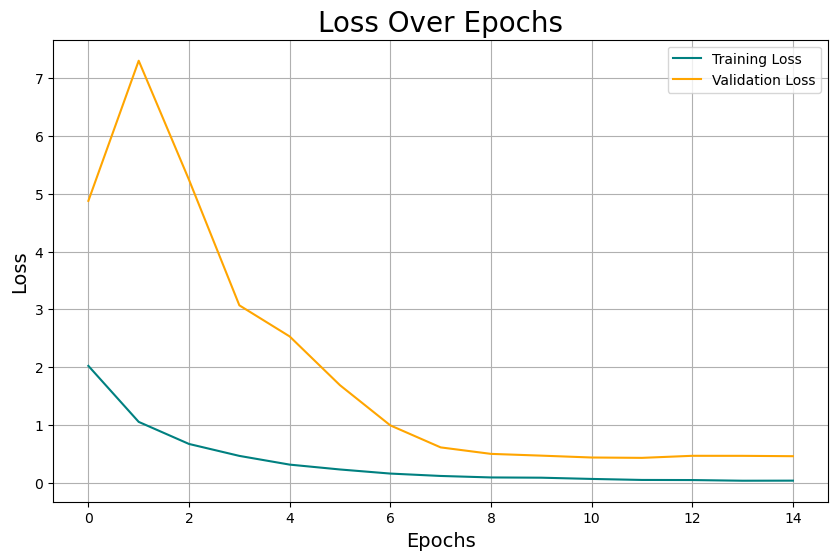

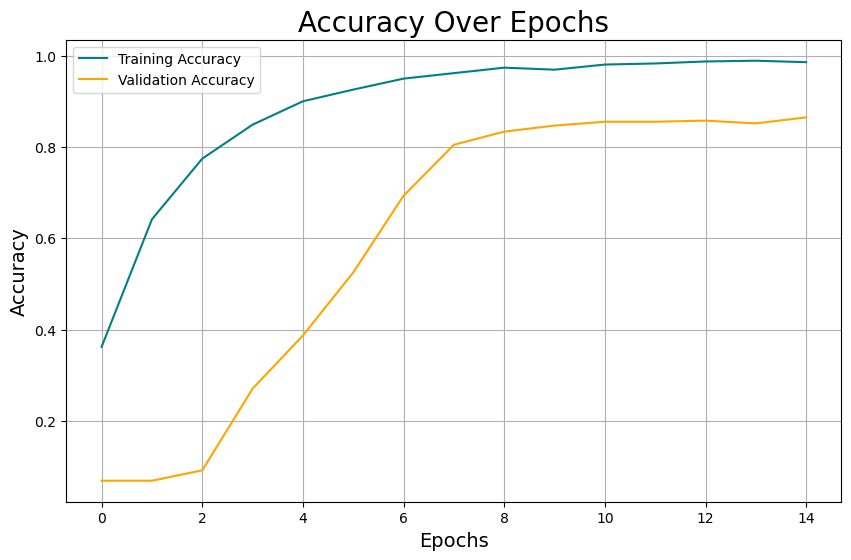

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.8642 - loss: 0.5160
Test accuracy: 0.8737980723381042


In [14]:
# Plot performance (loss)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented_upd.history['loss'], color='teal', label='Training Loss')
plt.plot(history_augmented_upd.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot performance (accuracy)
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented_upd.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history_augmented_upd.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = augmented_model_upd.evaluate(test_mixed_images_normalized, test_mixed_labels)

# Print the test accuracy
print(f"Test accuracy: {test_acc}")

Model was slighty improved however the difference is rather minor. We assume that it is already a good result. 

In [15]:
#save a model 
augmented_model_upd.save("augmented_model_upd.keras")

In [11]:
#load the model
augmented_model_upd = load_model("augmented_model_upd.keras")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


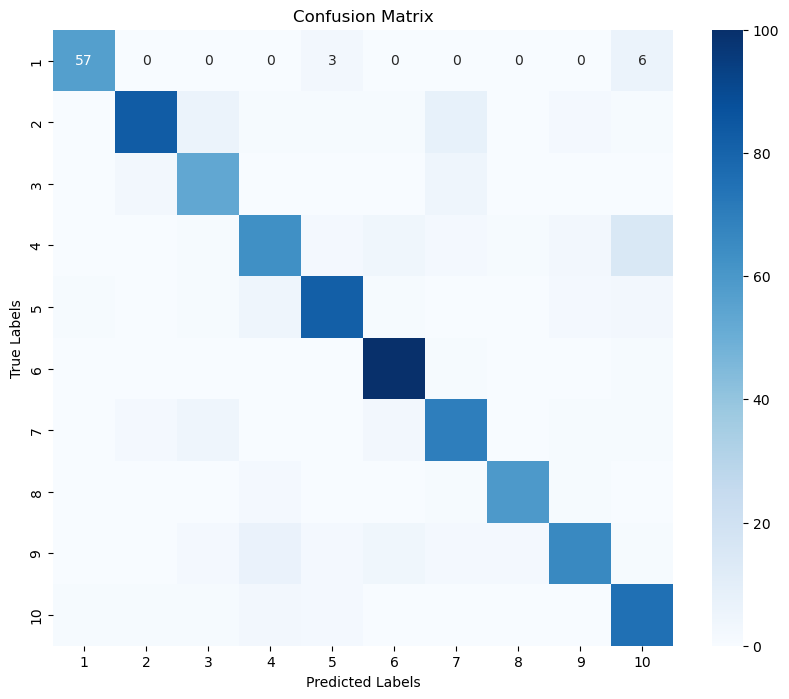

In [12]:
# Generate predictions for the test set
test_predictions = augmented_model_upd.predict(test_mixed_images_normalized)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_mixed_labels, test_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Prediction results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


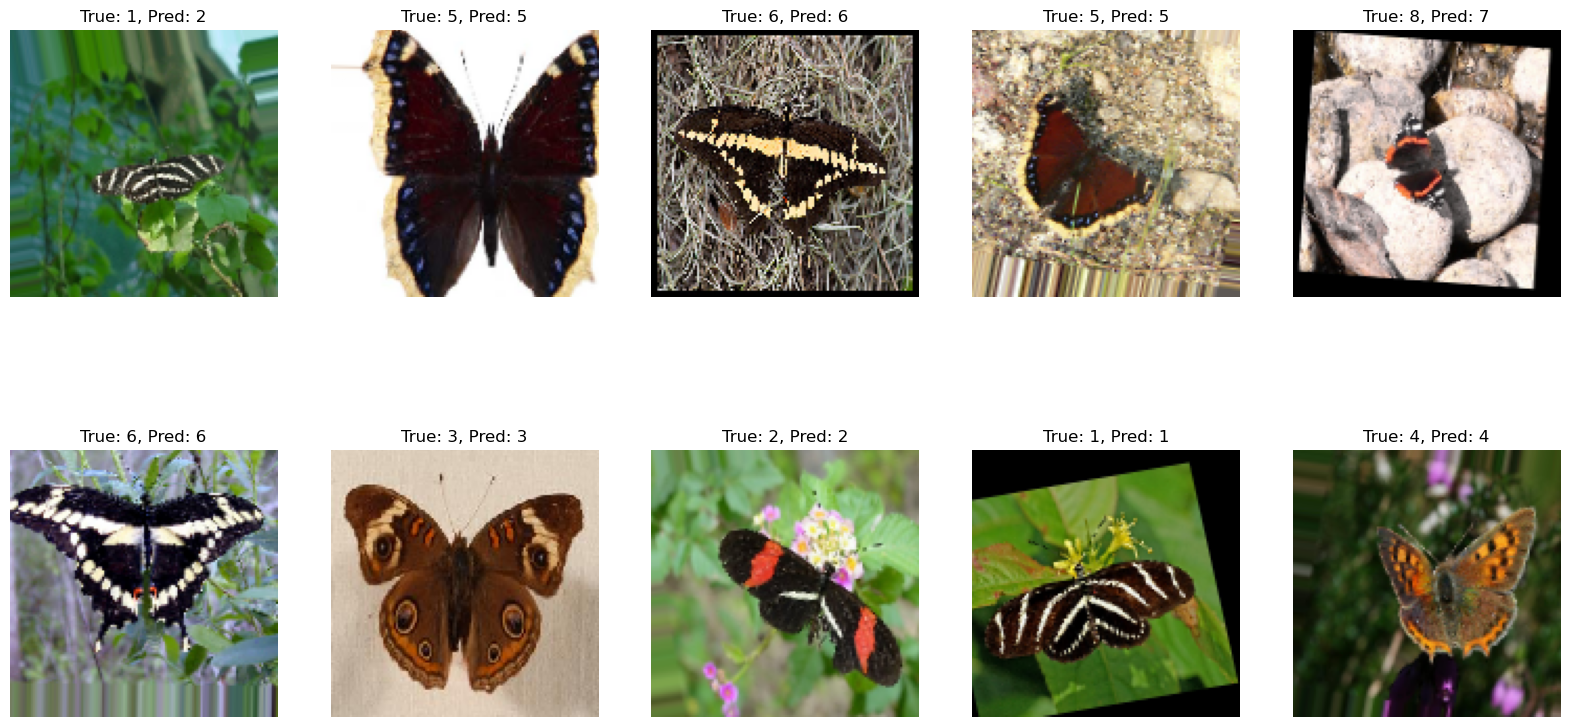

In [15]:
# Select a random subset of images from the test set
num_images_to_plot = 10  # Number of images to plot
random_indices = random.sample(range(len(test_mixed_images_normalized)), num_images_to_plot)
selected_images = test_mixed_images_normalized[random_indices]
selected_true_labels = test_mixed_labels[random_indices]

# Generate predictions for these selected images
selected_predictions = augmented_model_upd.predict(selected_images)
selected_pred_labels = np.argmax(selected_predictions, axis=1)

# Plot the images with their original and predicted labels
plt.figure(figsize=(20, 10))
for i in range(num_images_to_plot):
    plt.subplot(2, 5, i+1)
    plt.imshow(selected_images[i])
    plt.title(f"True: {selected_true_labels[i]}, Pred: {selected_pred_labels[i]}")
    plt.axis('off')
plt.show()


Finding out which class get the least correct predictions.

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
Class 0: 57 correct predictions out of 66 (86.36%)
Class 1: 83 correct predictions out of 103 (80.58%)
Class 2: 53 correct predictions out of 61 (86.89%)
Class 3: 63 correct predictions out of 91 (69.23%)
Class 4: 82 correct predictions out of 95 (86.32%)
Class 5: 100 correct predictions out of 102 (98.04%)
Class 6: 70 correct predictions out of 82 (85.37%)
Class 7: 59 correct predictions out of 63 (93.65%)
Class 8: 66 correct predictions out of 86 (76.74%)
Class 9: 75 correct predictions out of 83 (90.36%)
Class with the least accuracy: 3 (69.23%)


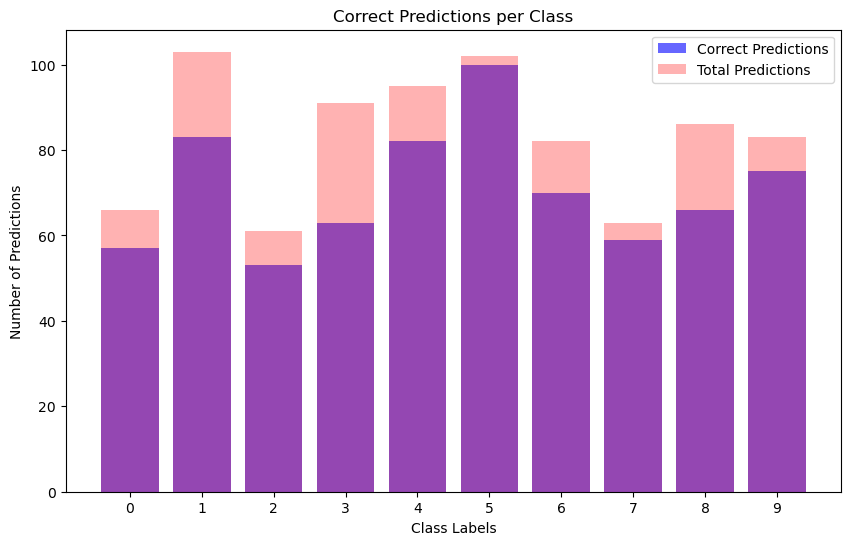

In [20]:
# Generate predictions for the entire test set
test_predictions = augmented_model_upd.predict(test_mixed_images_normalized)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compare predicted labels with true labels to determine correctness
correct_predictions = (test_pred_labels == test_mixed_labels)

# Count correct predictions and total predictions for each class
correct_counts = Counter()
total_counts = Counter()

for true_label, correct in zip(test_mixed_labels, correct_predictions):
    total_counts[true_label] += 1
    if correct:
        correct_counts[true_label] += 1

# Calculate accuracy for each class
accuracy_per_class = {}
for class_label in range(10): 
    total = total_counts[class_label]
    correct = correct_counts[class_label]
    accuracy = correct / total if total > 0 else 0
    accuracy_per_class[class_label] = accuracy
    print(f"Class {class_label}: {correct} correct predictions out of {total} ({accuracy * 100:.2f}%)")

# Find the class with the least accuracy
least_accurate_class = min(accuracy_per_class, key=accuracy_per_class.get)
print(f"Class with the least accuracy: {least_accurate_class} ({accuracy_per_class[least_accurate_class] * 100:.2f}%)")

# Plot histogram of correct predictions per class
classes = list(range(10))  # Assuming there are 10 classes (0-9)
correct_pred_values = [correct_counts[class_label] for class_label in classes]
total_pred_values = [total_counts[class_label] for class_label in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, correct_pred_values, color='blue', alpha=0.6, label='Correct Predictions')
plt.bar(classes, total_pred_values, color='red', alpha=0.3, label='Total Predictions')
plt.xlabel('Class Labels')
plt.ylabel('Number of Predictions')
plt.title('Correct Predictions per Class')
plt.legend()
plt.xticks(classes)
plt.show()
